# Post-processing for membrane-based cell segmentation
In this notebook we use a seeded-watershed algorithm from [napari-segment-blobs-and-things-with-membranes](https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes) to segment cells and afterward filter the cells to remove spuriously segmented objects.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

import pyclesperanto_prototype as cle
import napari_segment_blobs_and_things_with_membranes as nsbatwm

The following example image data is a timelapse of cells marked with a membrane marker. The dataset is a courtesy of Sascha M. Kuhn, Nadler Lab, MPI-CBG Dresden.

In [2]:
image_timelapse = imread("../../data/membrane_2d_timelapse.tif")
image_timelapse.shape

(5, 256, 256)

We start by extracting a single channel, single time point example from the middle of the timelapse stack.

In [3]:
membranes_single_slice = image_timelapse[2]
membranes_single_slice.shape

(256, 256)

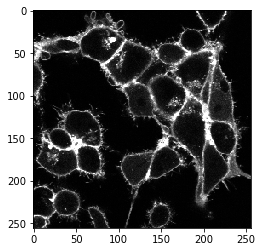

In [4]:
cle.imshow(membranes_single_slice)

The napari-segment-blobs-and-things-with-membrances plugin is scriptable. All commands that can be called from the menu, can also be called from python. For example the local-minima-seeded watershed can be called like this:

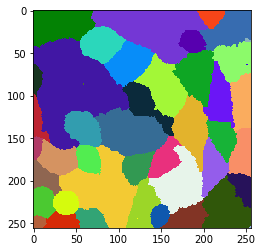

In [5]:
cell_labels_pre = nsbatwm.local_minima_seeded_watershed(membranes_single_slice, spot_sigma=7)

cle.imshow(cell_labels_pre, labels=True)

Obviously, there are too many objects segmented and labeled after this step. Hence, we should explore which properties of those cells allow us to differentiate real cells and segmented background. For example, as the cells have membrane also in front and back, we perceive this signal as higher intensity in real cells. To visualize this quantitatively, we draw a mean-intensity map of the cells. In this map, every pixel that belongs to a given cell gets the mean average signal intensity of the whole cell.

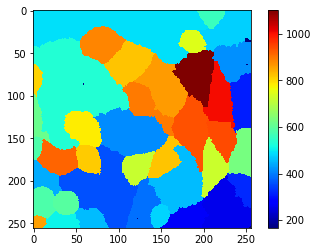

In [6]:
mean_intensity_map = cle.mean_intensity_map(membranes_single_slice, cell_labels_pre)

cle.imshow(mean_intensity_map, colorbar=True, colormap='jet')

From this view and the color-bar on the side we can guess a threshold, e.g. `650`, which allows us to separate real cells from background. If such a simple thresholding method does not work and/or a single parameter such as mean intensity does not allow this differentiation, it may make sense to use object classifiers, a.k.a. machine learning. For example the [napari-accelerate-pixel-and-object-classification](https://www.napari-hub.org/plugins/napari-accelerated-pixel-and-object-classification) plugin and the underlying [apoc library](https://github.com/haesleinhuepf/apoc) can help.

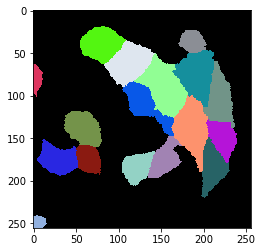

In [7]:
cell_labels = cle.exclude_labels_with_map_values_within_range(mean_intensity_map, cell_labels_pre, maximum_value_range=700)

cle.imshow(cell_labels, labels=True)

## Applying the workflow to the whole time-lapse
We have now a rough idea of how a workflow for segmenting the cells looks like. We re-write the whole workflow in a function. The function also has proper documentation so that future-self still knows what the function does.

In [8]:
def cell_segmentation_worflow(membranes_single_slice, cell_segmentation_spot_sigma=7, maximum_mean_intensity_per_cell=700):
    """Cell segmentation based on membrane signal
    
    Parameters
    ----------
    membranes_single_slice
        Image to segment
    cell_segmentation_spot_sigma: float, optional
        Allows to configure segmentation. The higher sigma, the less cells will be there.
    maximum_mean_intensity_per_cell: float, optional
        Threshold for mean-intensity per cell. Cells with signal below will be excluded
        
    Returns
    -------
    cell label image
    """
    
    # label cell candidates
    cell_labels_pre = nsbatwm.local_minima_seeded_watershed(
                                membranes_single_slice, 
                                spot_sigma=cell_segmentation_spot_sigma)
    
    # measure intensity in all candidates
    mean_intensity_map = cle.mean_intensity_map(
                                membranes_single_slice, 
                                cell_labels_pre)
    
    # exclude candidates with low signal
    cell_labels = cle.exclude_labels_with_map_values_within_range(
                        mean_intensity_map, cell_labels_pre, 
                        maximum_value_range=maximum_mean_intensity_per_cell)
    
    return cell_labels

This function, we can apply to the whole time lapse and take a look if the segmentation also works ok in all time-points.

t =  0 , number of cells:  17.0


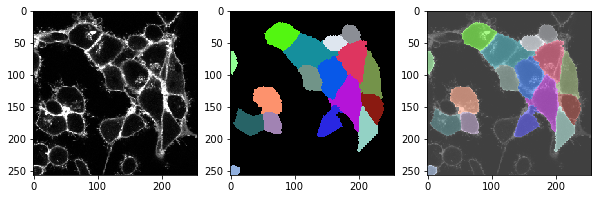

t =  1 , number of cells:  18.0


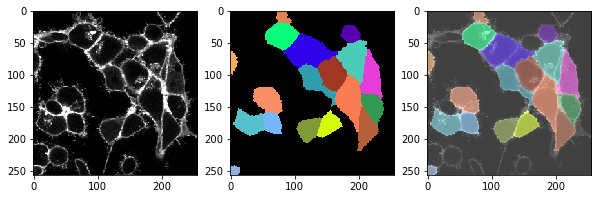

t =  2 , number of cells:  17.0


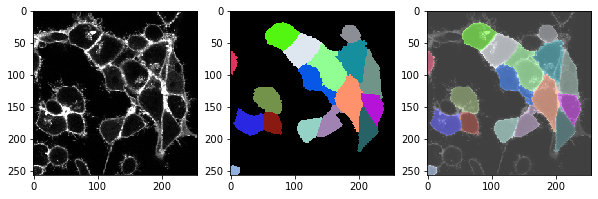

t =  3 , number of cells:  18.0


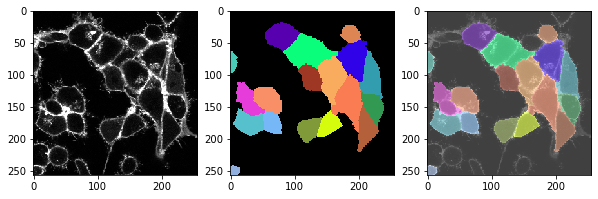

t =  4 , number of cells:  17.0


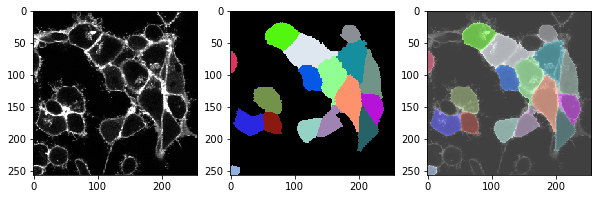

In [9]:
for t in range(len(image_timelapse)):
    # extrace a single slice / time point
    membranes_single_slice = image_timelapse[t]
    
    # segment cells 
    cell_labels = cell_segmentation_worflow(membranes_single_slice)

    # print headline
    print("t = ", t, ", number of cells: ", cell_labels.max())
    
    # show three images: image, labels, overlay
    fix, axs = plt.subplots(1, 3, figsize=(10,10))
    
    cle.imshow(membranes_single_slice, plot=axs[0])
    cle.imshow(cell_labels, plot=axs[1], labels=True)
    cle.imshow(membranes_single_slice, plot=axs[2], alpha=0.5, continue_drawing=True)
    cle.imshow(cell_labels, plot=axs[2], labels=True, alpha=0.5)
    plt.show()
    

## Exercise
Instead of filtering out cells with low signal intensity, filter out cells that are large and/or touch the image border. Apply the new workflow to the whole timelapse.